# The grand canonical ensemble


Given $H$, $P(\infty)$ and $\mu$, calculate
$$
    P(\beta) \approx \Omega(\beta)^{\dagger}\Omega(\beta),
$$
where
$$
    \Omega(\beta) = e^{-\frac{\beta}   {2} \mathcal{H}_{>}} F\left( e^{-\beta \mathcal{H}_{>}} 
    \right) ( I - P(\infty))
    + 
    F\left(  e^{\beta\mathcal{H}_{<}} 
    \right) P(\infty),
$$

$$
    \mathcal{H}_{>} = \frac{1}{2} \{H-\mu I, I - P(\infty)\}, \qquad 
    \mathcal{H}_{<} = \frac{1}{2} \{H-\mu I, P(\infty)\}.
$$
$$
    F(X) \approx (-576 + 408\sqrt{2}) I
        + (6256 - 4424\sqrt{2})X 
        + (-14832 + 10488\sqrt{2})X^2 
        + (9560 - 6760\sqrt{2})X^3.
$$

In [1]:
from scipy.io import mmread
import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import eigh, norm 

#### Counter to count the total number of matrix matrix multiplications

In [2]:
n_mtx_mult = 0

In [3]:
beta = 10

Load matrices in nonorthogonal basis

In [4]:
%ls data

Al128_H.mtx      Al250_meta.yaml  Si108_meta.yaml  Si32_meta.yaml
Al128_S.mtx      Al54_H.mtx       Si216_H.mtx      Si64_H.mtx
Al128_meta.yaml  Al54_S.mtx       Si216_S.mtx      Si64_S.mtx
Al16_H.mtx       Al54_meta.yaml   Si216_meta.yaml  Si64_meta.yaml
Al16_S.mtx       Si108_H.mtx      Si32_H.mtx
Al16_meta.yaml   Si108_S.mtx      Si32_S.mtx


In [5]:
matrices_path = "al/"
nono_H = mmread(matrices_path + "Al128_H.mtx")
S = mmread(matrices_path + "Al128_S.mtx")

data = "data"
geom = "Al128"

H = mmread(f"{data}/{geom}_H.mtx")
S = mmread(f"{data}/{geom}_S.mtx")

Orthogonalize the loaded Hamiltonian to get $H$

In [6]:
def funm_herm(a, func):
    w, v = eigh(a)
    w = func(w)
    return (v * w) @ v.conj().T

isq = funm_herm(S.toarray(), lambda x: -1/np.sqrt(x))

H = isq @ nono_H @ isq

Set chemical potential $\mu$ at half-filling

In [7]:
E = eigh(H, eigvals_only=True)
nel = E.size
mu = E[int(nel/2)-1] + 0.5*(E[int(nel/2)] - E[int(nel/2)-1])

The exact Fermi-Dirac distribution

In [8]:
FD_exact = np.exp(-beta * (E - mu)) / (1 + np.exp(-beta * (E - mu)))

Get the zero temperature state 

In [9]:
P_infty = funm_herm(H, lambda x: (x < mu))

In [10]:
assert np.allclose(P_infty, P_infty @ P_infty), "P_infty is not a projector!"

## Implementing matrix exponentiation via squaring and squaring and minimal polynomial 

In [11]:
def expm_specialized(A):
    
    # scaling
    A_L1 = norm(A, 1)
    
    maxnorm = 1
    n_squarings = max(0, int(np.ceil(np.log2(A_L1 / maxnorm))))
    A = A / 2 ** n_squarings
    
    c = [
        -464 + 1264*np.exp(-1),
        -5760 + 15660*np.exp(-1),
        -14700 + 39960*np.exp(-1),
        -9940 + 27020*np.exp(-1)
    ]
    
    # how many matrix multiplications it takes to get R
    cost_R = len(c) - 2
    
    I = np.eye(A.shape[0])
    
    R = A * c.pop() + I * c.pop()
    
    while c:
        R = c.pop() * I + A @ R
    
    # squaring step to undo scaling
    for _ in range(n_squarings):
        R = R @ R
    
    print(f"It took {cost_R + n_squarings} matrix multiplications to get expm")
    
    # Update the number of matrix-matrix multiplications
    global n_mtx_mult
    n_mtx_mult += cost_R + n_squarings
    
    return R

In [12]:
I = np.eye(H.shape[0])

Get $\mathcal{H}_{>} = \frac{1}{2} \{H-\mu I, I - P(\infty)\}$ and its matrix exponent

In [13]:
def anticommut(a, b):
    
    # Update the number of matrix-matrix multiplications
    global n_mtx_mult
    n_mtx_mult += 1
    
    temp = a @ b
    return temp + temp.conj().T
    # return a @ b + b @ a

H_larger = 0.5 * anticommut(H - mu * I, I - P_infty)

exp_half_H_larger = expm_specialized(-0.5 * beta * H_larger)

It took 6 matrix multiplications to get expm


Get $\mathcal{H}_{<} = \frac{1}{2} \{H-\mu I, P(\infty)\}$ and its matrix exponent

In [14]:
H_less = 0.5 * anticommut(H - mu * I, P_infty)

exp_H_less = expm_specialized(beta * H_less)

It took 7 matrix multiplications to get expm


In [15]:
def Fm(A):
    
    c = [
        -576 + 408*np.sqrt(2),
         6256 - 4424*np.sqrt(2),
         -14832 + 10488*np.sqrt(2),
         9560 - 6760*np.sqrt(2)
    ]
    
    # how many matrix multiplications it takes to get R
    cost_R = len(c) - 2
    
    I = np.eye(A.shape[0])
    
    R = A * c.pop() + I * c.pop()
    
    while c:
        R = c.pop() * I + A @ R
    
    print(f"It took {cost_R} matrix multiplications to get (1 + x) ** -1/2")
    
    # Update the number of matrix-matrix multiplications
    global n_mtx_mult
    n_mtx_mult += cost_R
    
    return R

## Getting $\Omega(\beta)$ and $P(\beta)$

In [16]:
Omega = exp_half_H_larger @ Fm(exp_half_H_larger @ exp_half_H_larger) @ (I - P_infty)
Omega += Fm(exp_H_less) @ P_infty

P_approx = Omega.conj().T @ Omega

# Update the number of matrix-matrix multiplications
n_mtx_mult += 5

It took 2 matrix multiplications to get (1 + x) ** -1/2
It took 2 matrix multiplications to get (1 + x) ** -1/2


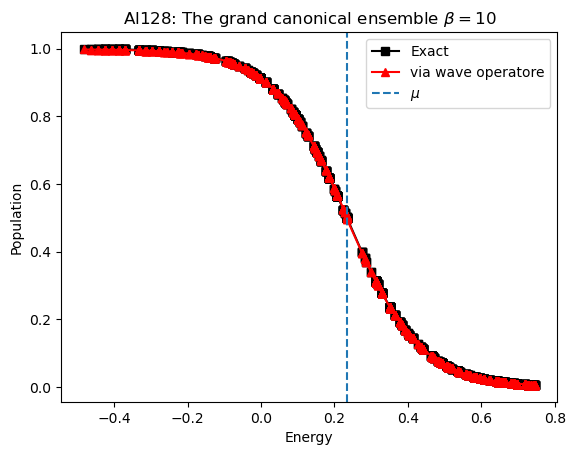

In [18]:
plt.title(f"{geom}: The grand canonical ensemble $\\beta = {beta}$")

plt.plot(E, FD_exact, 'ks-', label="Exact")
plt.plot(
    E,
    eigh(P_approx, eigvals_only=True)[::-1],
    'r^-',
    label="via wave operatore"
)
plt.axvline(mu, linestyle='--', label="$\mu$")

plt.xlabel("Energy")
plt.ylabel("Population")
plt.legend(numpoints=1)
plt.savefig(f"results_{geom}_beta={beta}.png")
plt.show()

#### Total number matrix-matrix multiplications

In [19]:
n_mtx_mult

24